In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_27_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fa46b88e900> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(18083)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

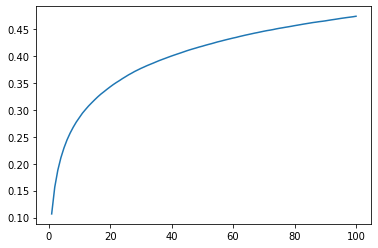

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.1068, 0.1564, 0.1879, 0.2111, 0.2292, 0.2442, 0.2568, 0.2676, 0.2772,
        0.2855, 0.2937, 0.3005, 0.3071, 0.3130, 0.3187, 0.3241, 0.3292, 0.3336,
        0.3382, 0.3425, 0.3467, 0.3506, 0.3541, 0.3579, 0.3614, 0.3649, 0.3680,
        0.3712, 0.3740, 0.3768, 0.3794, 0.3820, 0.3843, 0.3866, 0.3891, 0.3914,
        0.3936, 0.3957, 0.3979, 0.3999, 0.4019, 0.4038, 0.4057, 0.4077, 0.4097,
        0.4115, 0.4132, 0.4149, 0.4166, 0.4181, 0.4198, 0.4214, 0.4228, 0.4245,
        0.4261, 0.4275, 0.4290, 0.4305, 0.4318, 0.4332, 0.4344, 0.4359, 0.4373,
        0.4386, 0.4398, 0.4411, 0.4424, 0.4434, 0.4447, 0.4459, 0.4470, 0.4479,
        0.4490, 0.4502, 0.4513, 0.4522, 0.4532, 0.4541, 0.4551, 0.4562, 0.4572,
        0.4582, 0.4592, 0.4601, 0.4611, 0.4620, 0.4628, 0.4636, 0.4643, 0.4651,
        0.4661, 0.4670, 0.4678, 0.4687, 0.4697, 0.4705, 0.4713, 0.4720, 0.4728,
        0.4737])

In [18]:
percentages.max()

tensor(0.4737)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.588492  , 0.57097725, 0.55961175, 0.55124511, 0.54473938,
       0.53930583, 0.53461487, 0.53059471, 0.52713329, 0.52392068,
       0.52136841, 0.51886703, 0.51658332, 0.51443773, 0.51257468,
       0.51068763, 0.50907017, 0.50751433, 0.5060166 , 0.50464944,
       0.50331069, 0.50204373, 0.50084483, 0.49967768, 0.49862492,
       0.49758569, 0.49660616, 0.49565506, 0.49470499, 0.49377791,
       0.49292398, 0.49203503, 0.49121194, 0.49041885, 0.489677  ,
       0.48893518, 0.48824894, 0.48752889, 0.48685031, 0.48619651,
       0.48556768, 0.48495727, 0.48432993, 0.48372843, 0.48312649,
       0.48259642, 0.48202295, 0.48147842, 0.48093309, 0.48039954,
       0.4798934 , 0.47934892, 0.47887257, 0.47837787, 0.47789419,
       0.4774299 , 0.47698044, 0.47651889, 0.47605176, 0.47559007,
       0.47514604, 0.4747128 , 0.47427898, 0.47385438, 0.47341904,
       0.47302856, 0.47265609, 0.47227416, 0.47189458, 0.47153917,
       0.4711684 , 0.47079465, 0.47044464, 0.47008135, 0.46974

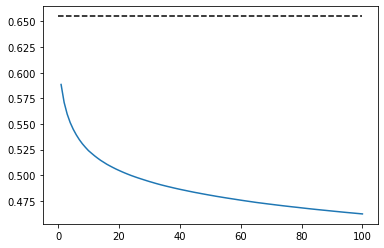

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa46a64e6c0> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(18795)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.8249232242633298

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0,  10839,  36054, ...,  69466,  37512, 109170],
       [     1, 154949,  69168, ..., 146993, 114117,  69016],
       [     2, 122406, 144275, ...,  56345,  67785,  98336],
       ...,
       [169340, 107677,  32268, ..., 121241,  45789,  40479],
       [169341, 166389, 140969, ...,  74293, 114548, 105771],
       [169342,  62601, 115370, ...,   1180, 156497,  62282]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.6498464485266595

In [40]:
distances

array([[0.99999994, 0.9924412 , 0.98246956, ..., 0.8915764 , 0.8915437 ,
        0.8913003 ],
       [0.9999998 , 0.9922197 , 0.97096294, ..., 0.92360765, 0.9234815 ,
        0.92339396],
       [1.        , 0.9933581 , 0.9906797 , ..., 0.9428892 , 0.9428735 ,
        0.9428676 ],
       ...,
       [0.99999994, 0.96201086, 0.9502299 , ..., 0.8792074 , 0.8787245 ,
        0.87845016],
       [1.        , 0.95980334, 0.9587528 , ..., 0.91272795, 0.91236717,
        0.9123274 ],
       [0.99999994, 0.96883595, 0.95787984, ..., 0.92891806, 0.9285777 ,
        0.9283046 ]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

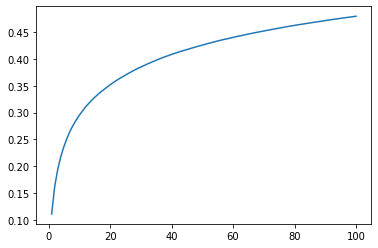

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1110, 0.1627, 0.1947, 0.2184, 0.2368, 0.2523, 0.2655, 0.2765, 0.2862,
        0.2950, 0.3026, 0.3101, 0.3166, 0.3228, 0.3283, 0.3335, 0.3384, 0.3429,
        0.3472, 0.3516, 0.3557, 0.3594, 0.3631, 0.3664, 0.3697, 0.3731, 0.3761,
        0.3792, 0.3821, 0.3848, 0.3874, 0.3902, 0.3926, 0.3951, 0.3974, 0.3998,
        0.4021, 0.4043, 0.4062, 0.4084, 0.4102, 0.4121, 0.4140, 0.4156, 0.4174,
        0.4190, 0.4208, 0.4225, 0.4241, 0.4256, 0.4272, 0.4289, 0.4302, 0.4318,
        0.4334, 0.4347, 0.4361, 0.4373, 0.4386, 0.4400, 0.4413, 0.4426, 0.4438,
        0.4450, 0.4463, 0.4474, 0.4486, 0.4498, 0.4508, 0.4519, 0.4530, 0.4541,
        0.4553, 0.4562, 0.4573, 0.4584, 0.4594, 0.4605, 0.4614, 0.4624, 0.4634,
        0.4643, 0.4651, 0.4660, 0.4669, 0.4678, 0.4687, 0.4696, 0.4704, 0.4713,
        0.4722, 0.4731, 0.4739, 0.4747, 0.4755, 0.4764, 0.4771, 0.4778, 0.4787,
        0.4794])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.59149773, 0.57549766, 0.56386742, 0.55579947, 0.54907614,
       0.543841  , 0.53912558, 0.53524282, 0.53158776, 0.5285899 ,
       0.52587782, 0.52342041, 0.52116982, 0.5189999 , 0.51708229,
       0.51521911, 0.51344313, 0.51184086, 0.51043305, 0.50906533,
       0.50775054, 0.5064769 , 0.5053153 , 0.50420498, 0.50315017,
       0.50209475, 0.50111006, 0.50007635, 0.49915464, 0.49823219,
       0.49731686, 0.49652628, 0.49570846, 0.49487813, 0.49411009,
       0.49341753, 0.49268884, 0.49198497, 0.49134824, 0.49068237,
       0.49004524, 0.48940738, 0.48876046, 0.48814456, 0.48757203,
       0.48703506, 0.48644945, 0.48593117, 0.48542284, 0.48489291,
       0.48438701, 0.48385593, 0.4833722 , 0.48288494, 0.48242615,
       0.48196802, 0.48151458, 0.48108002, 0.48064629, 0.48019414,
       0.4797604 , 0.4793496 , 0.47891829, 0.47852205, 0.4780933 ,
       0.47769258, 0.47729712, 0.47688715, 0.47647708, 0.4761026 ,
       0.47569892, 0.47531842, 0.47494867, 0.47460128, 0.47424

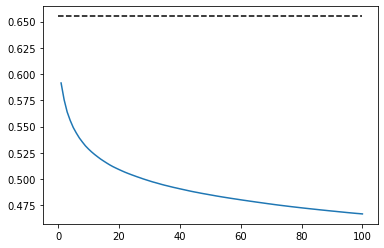

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa450c0bc00> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(392)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

81.81316954270005

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[108996,  22898,  55888, ...,  82852, 157913,  22025],
       [ 70003, 143566, 162823, ..., 108700,  98961,  56295],
       [121769,  91497,  77164, ...,  79506,  30617,  58701],
       ...,
       [ 66346,  70157,  67343, ..., 152416,  55713, 151482],
       [ 99734,  57440,  66346, ...,  94609,  12364,  48879],
       [129875,   3287, 122395, ...,  22846,  29157, 161424]])

In [61]:
sum(embeddings[0] * embeddings[411])

162.6263390854001

In [62]:
distances

array([[187.81989, 185.09314, 183.43033, ..., 160.07867, 159.79669,
        159.66924],
       [502.3239 , 475.5647 , 459.7809 , ..., 406.53564, 406.4297 ,
        406.30963],
       [359.70508, 344.62094, 341.88358, ..., 294.89438, 294.79272,
        294.74252],
       ...,
       [270.74625, 255.45013, 254.79774, ..., 219.07207, 218.98845,
        218.52286],
       [288.98633, 287.2118 , 277.8018 , ..., 240.91206, 240.74492,
        240.49036],
       [500.08582, 495.50748, 495.2341 , ..., 442.60803, 442.5536 ,
        442.49823]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

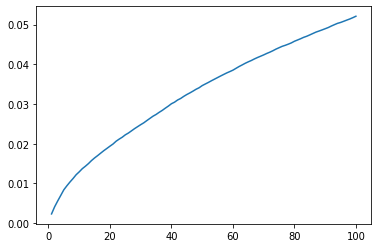

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0023, 0.0041, 0.0056, 0.0070, 0.0084, 0.0094, 0.0104, 0.0112, 0.0122,
        0.0129, 0.0137, 0.0143, 0.0150, 0.0158, 0.0164, 0.0170, 0.0176, 0.0182,
        0.0188, 0.0194, 0.0199, 0.0206, 0.0212, 0.0216, 0.0222, 0.0227, 0.0232,
        0.0238, 0.0243, 0.0248, 0.0253, 0.0258, 0.0264, 0.0269, 0.0274, 0.0279,
        0.0284, 0.0289, 0.0295, 0.0301, 0.0305, 0.0310, 0.0314, 0.0319, 0.0324,
        0.0328, 0.0332, 0.0337, 0.0341, 0.0346, 0.0350, 0.0354, 0.0359, 0.0363,
        0.0367, 0.0371, 0.0375, 0.0378, 0.0382, 0.0385, 0.0390, 0.0394, 0.0398,
        0.0403, 0.0406, 0.0410, 0.0414, 0.0417, 0.0420, 0.0424, 0.0427, 0.0431,
        0.0434, 0.0438, 0.0442, 0.0445, 0.0448, 0.0451, 0.0454, 0.0458, 0.0461,
        0.0464, 0.0468, 0.0471, 0.0474, 0.0478, 0.0481, 0.0484, 0.0487, 0.0490,
        0.0493, 0.0496, 0.0500, 0.0503, 0.0505, 0.0508, 0.0511, 0.0514, 0.0517,
        0.0521])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.32332013, 0.31463952, 0.30882292, 0.30439404, 0.30107061,
       0.29794756, 0.29553459, 0.29360086, 0.29137904, 0.28961988,
       0.28788425, 0.2863311 , 0.28488652, 0.28357155, 0.28247403,
       0.28136017, 0.28043397, 0.27947027, 0.27867203, 0.27783109,
       0.27701062, 0.27627091, 0.27555882, 0.27491467, 0.27434237,
       0.27382795, 0.27325999, 0.2726628 , 0.27212654, 0.2716715 ,
       0.27113876, 0.27068749, 0.2702267 , 0.2697522 , 0.26929098,
       0.26884637, 0.26843807, 0.26803324, 0.26769308, 0.26735708,
       0.26700003, 0.26662511, 0.26627435, 0.26594223, 0.2655994 ,
       0.26527341, 0.26495501, 0.26464028, 0.26433454, 0.26403914,
       0.26375359, 0.26345097, 0.26318929, 0.26292069, 0.26267409,
       0.26244505, 0.26217639, 0.26192973, 0.26169002, 0.26144954,
       0.26121695, 0.26098558, 0.26076698, 0.26056436, 0.26034798,
       0.26012805, 0.2598982 , 0.25972339, 0.25954013, 0.259333  ,
       0.25914277, 0.25893617, 0.25875092, 0.25857212, 0.25838

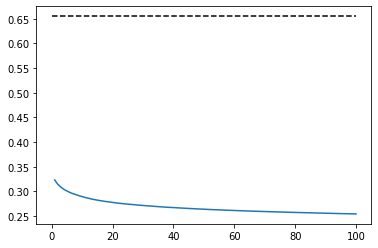

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

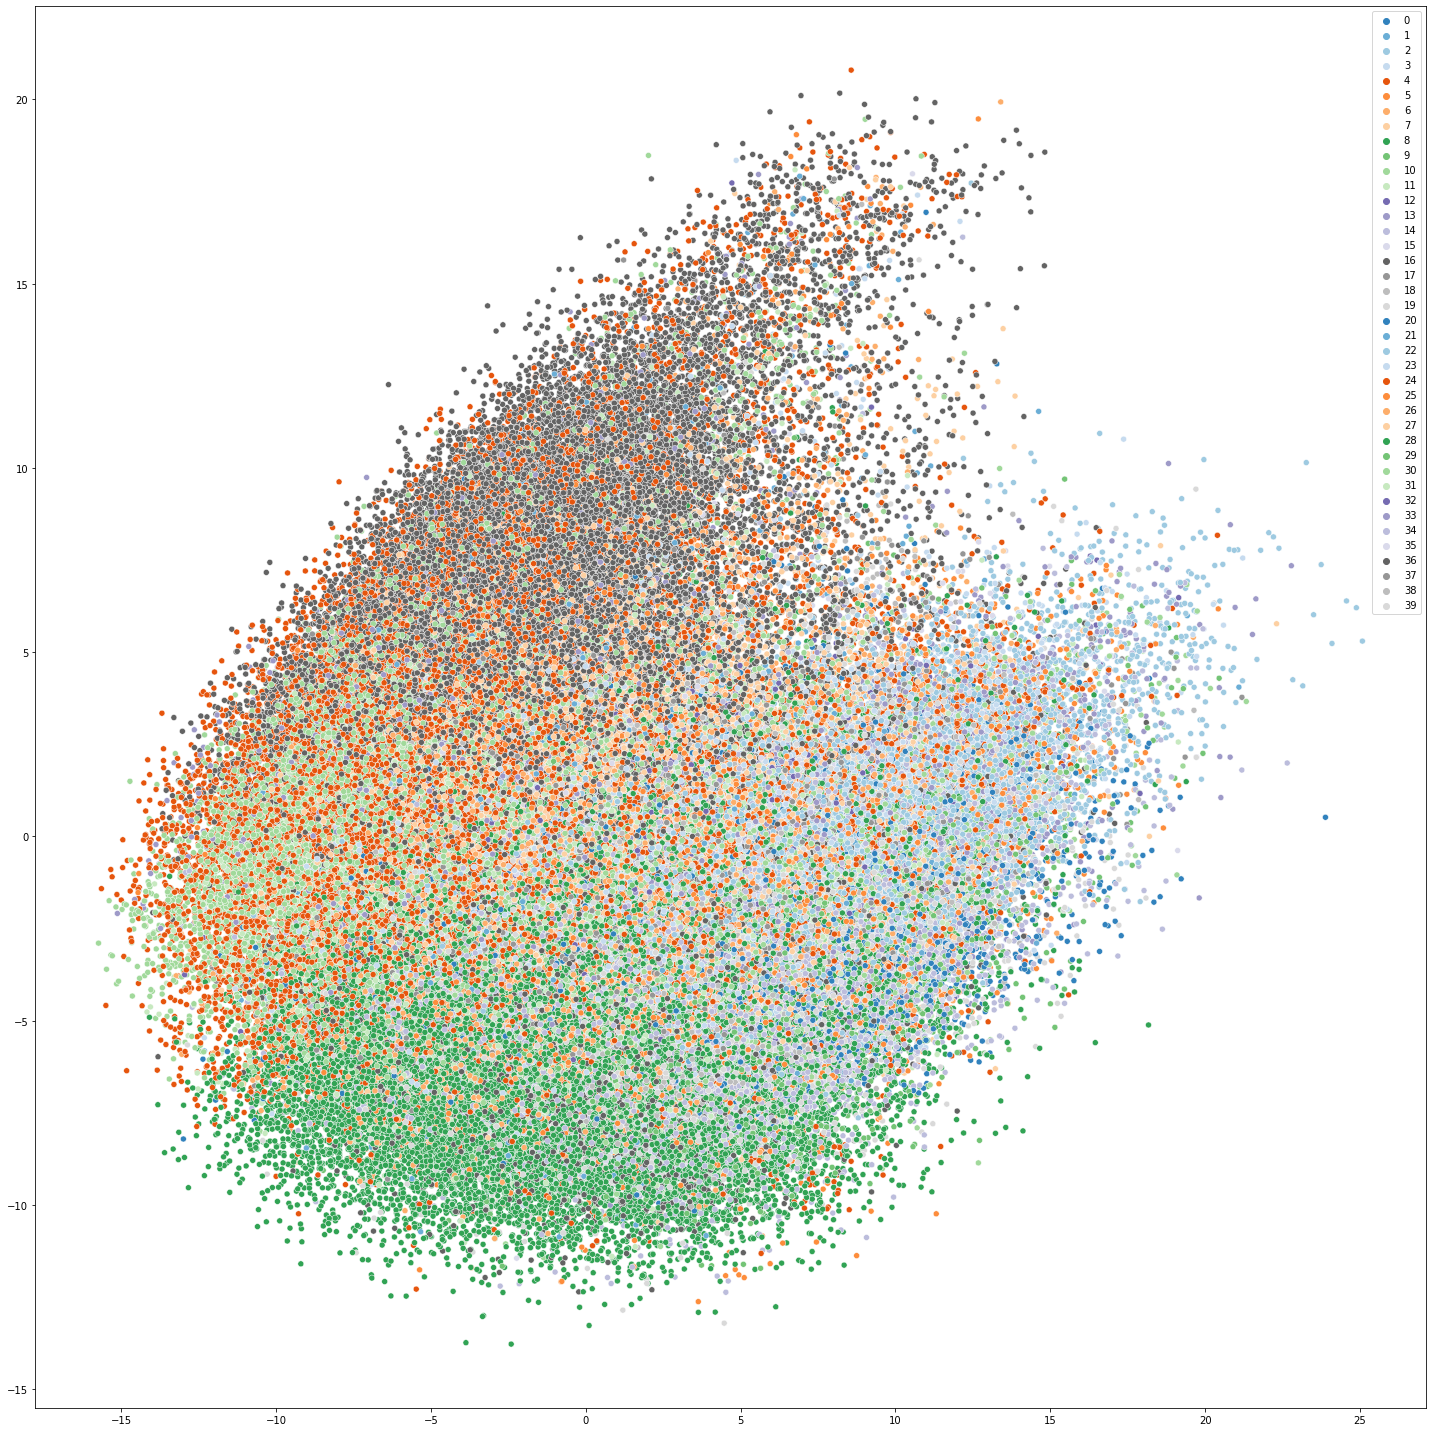

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

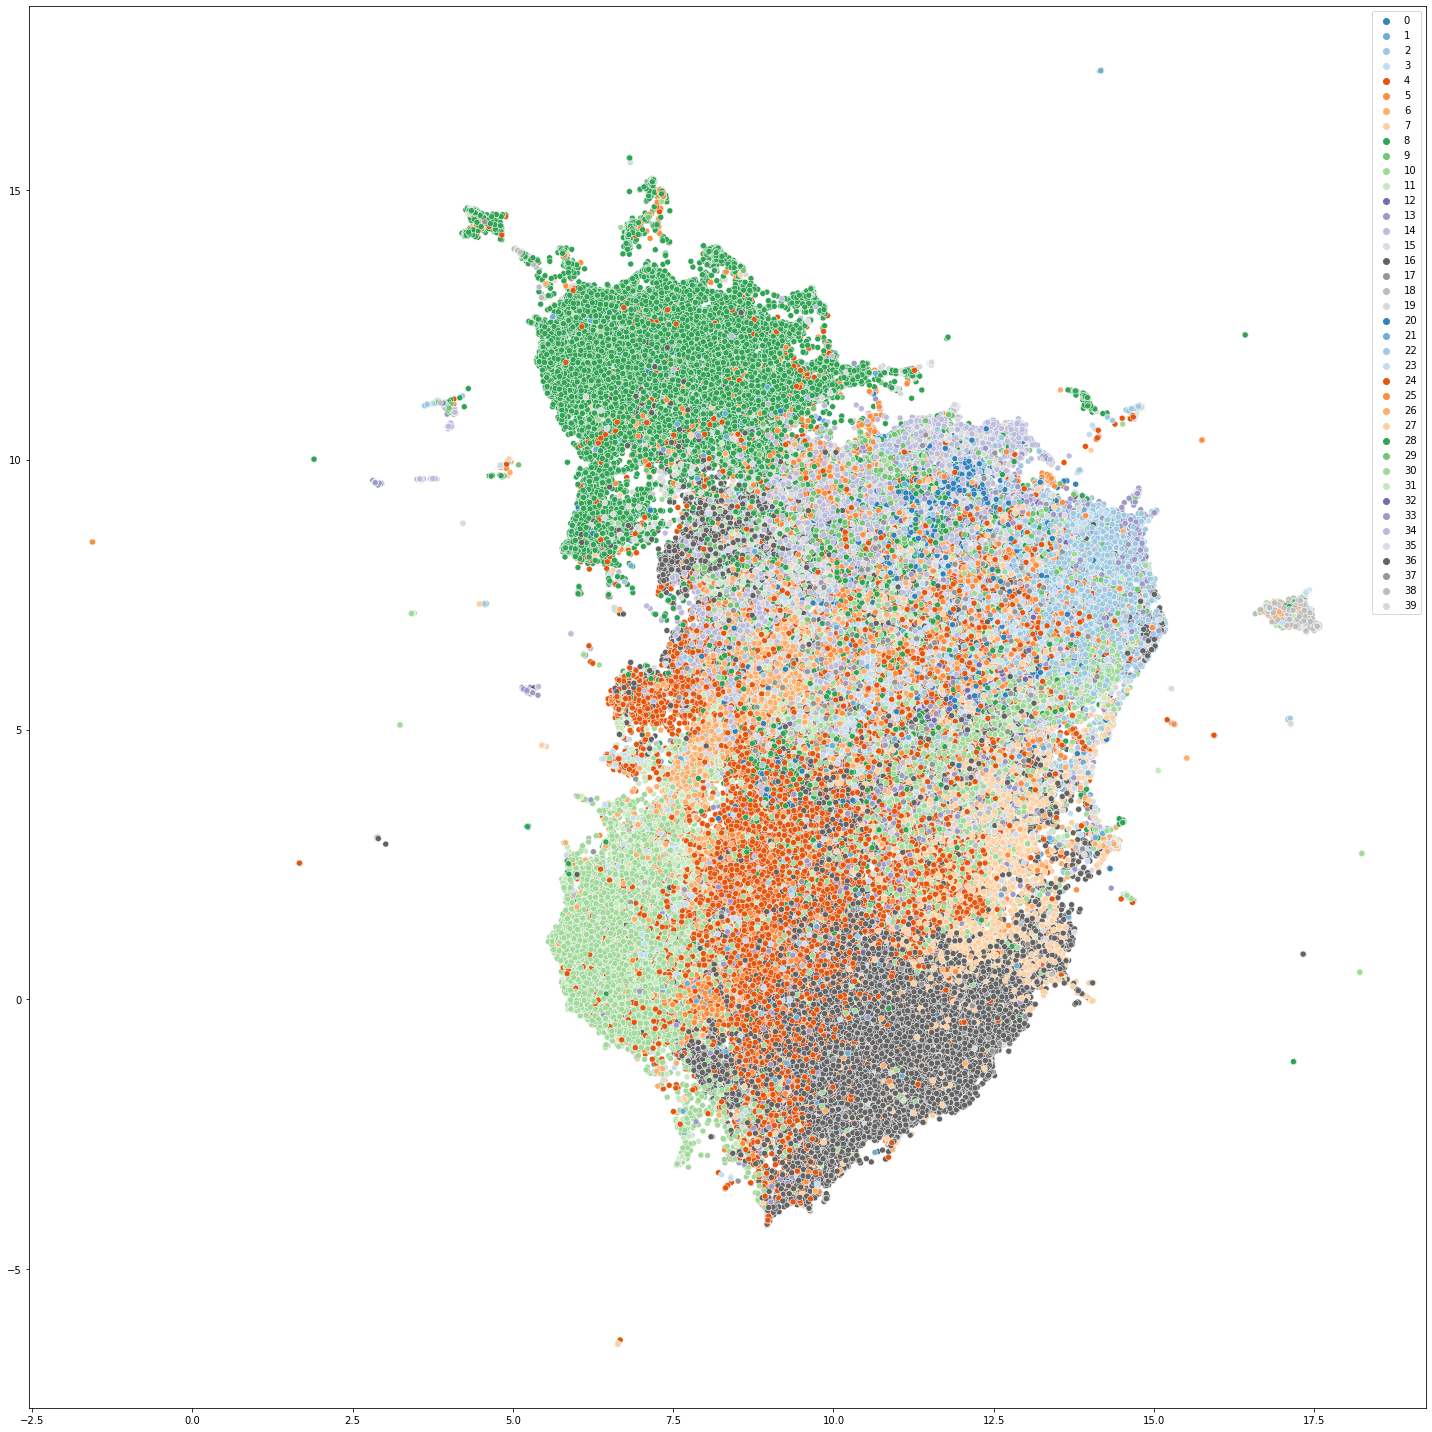

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

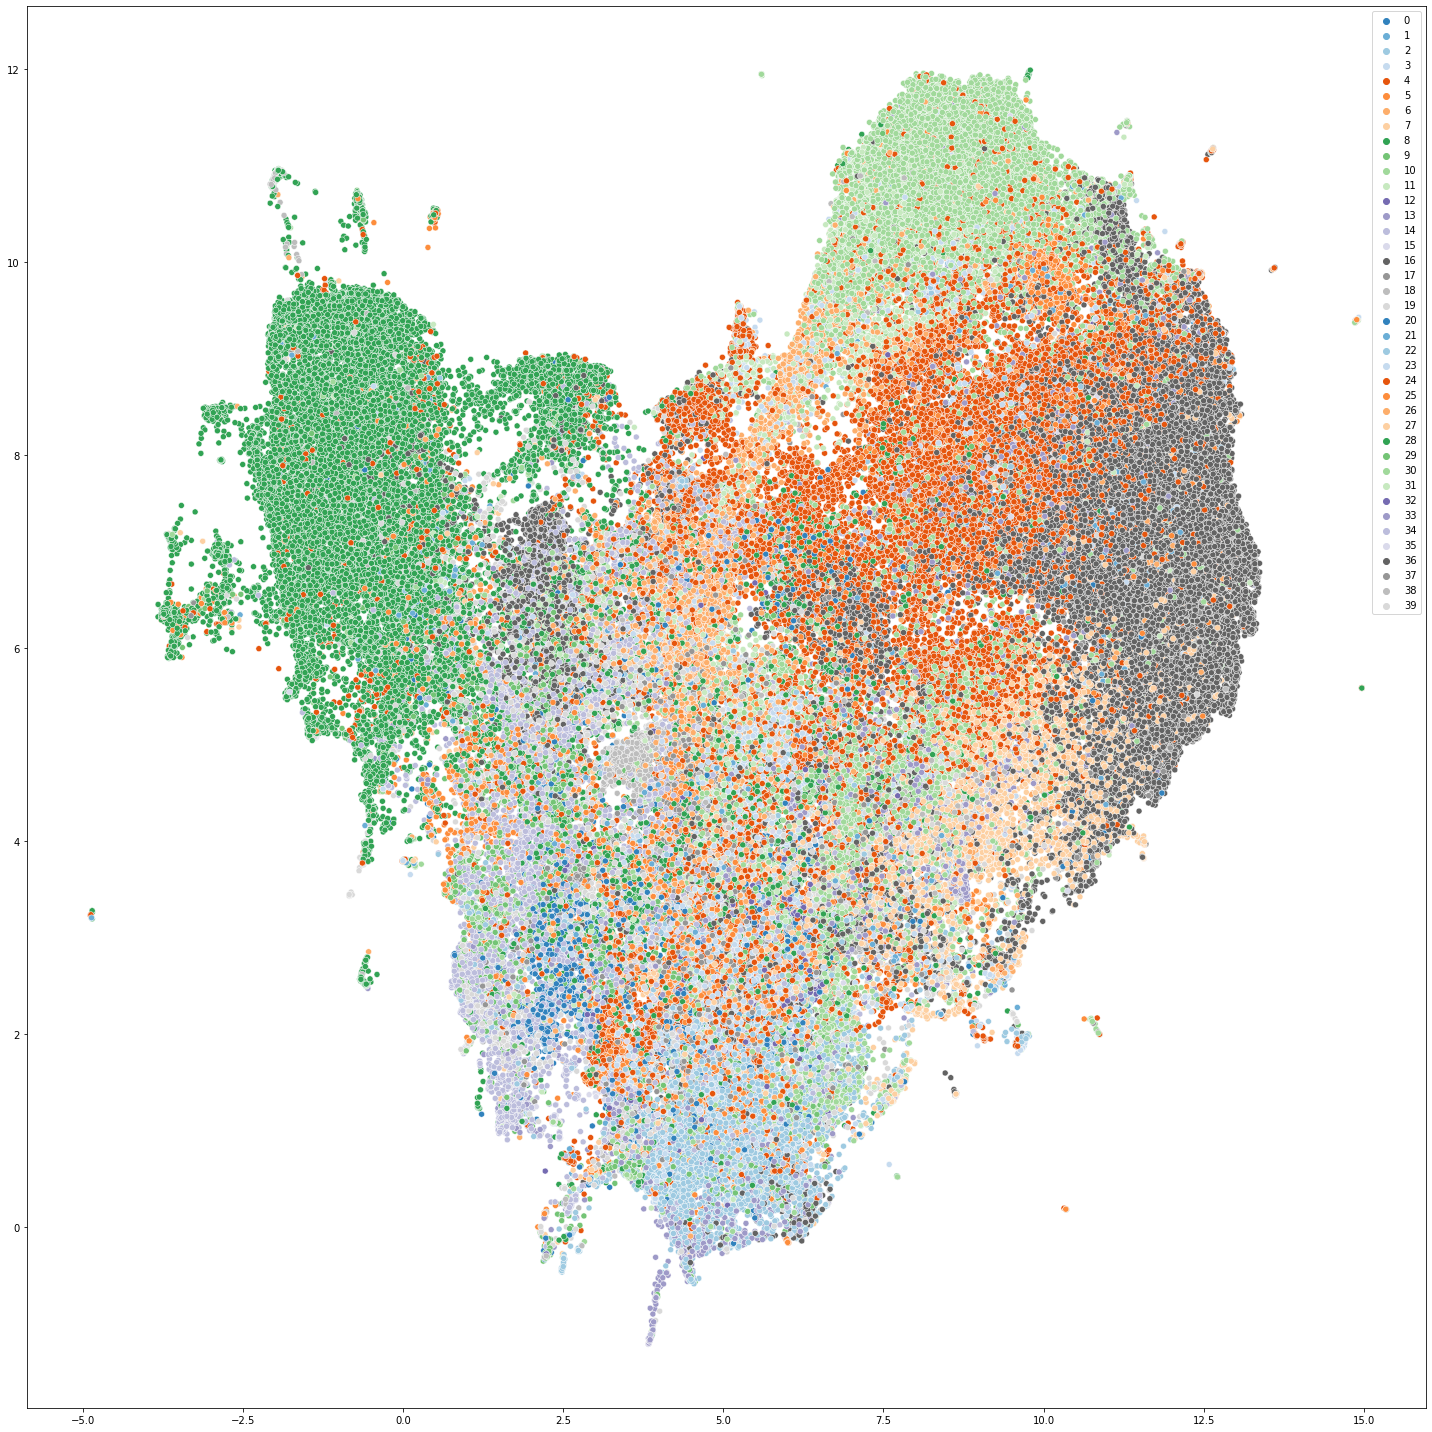

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()